## DATA PROCESSING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc 
import time

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

%matplotlib inline

In [2]:
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [3]:
(market_train_df, news_train_df) = env.get_training_data()

In [4]:
news_train_df.columns

Index(['time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'headline',
       'urgency', 'takeSequence', 'provider', 'subjects', 'audiences',
       'bodySize', 'companyCount', 'headlineTag', 'marketCommentary',
       'sentenceCount', 'wordCount', 'assetCodes', 'assetName',
       'firstMentionSentence', 'relevance', 'sentimentClass',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D',
       'volumeCounts7D'],
      dtype='object')

In [5]:
#dropping unnessary columns from the news dataset
drop_list = ['sourceTimestamp', 'firstCreated', 'sourceId', 'headline','takeSequence', 'subjects', 'audiences',
             'bodySize', 'marketCommentary']
news_train_df.drop(drop_list, axis=1, inplace=True)

In [6]:
#remove {} and '' from the assetCodes column of the news_train_df
news_train_df['assetCodes'] = news_train_df['assetCodes'].apply(lambda x:x[1:-1].replace("'", ""))

In [7]:
#Unstack news dataset using the assetCodes column
assetCodes = []
indices = []

for i, val in news_train_df['assetCodes'].iteritems():
    codes = val.split(",")
    assetCodes.extend(codes)
    list_index = [int(i)]*len(codes)
    indices.extend(list_index)

index_df = pd.DataFrame({'new_index': indices, 'assetCode': assetCodes})
del assetCodes, indices
gc.collect()

22

In [8]:
#Take a look at the new index_df dataframe
index_df.head()

,new_index,assetCode
0,0,0857.HK
1,0,PTR.N
2,0,0857.DE
3,0,0857.F
4,1,STA.N


In [9]:
#Dropping the assetCodes column before unstacking the news dataset
news_train_df.drop(['assetCodes'], axis=1, inplace=True)

In [10]:
#Merging the news_train_df and the index_df to unstack the news dataframe
news_train_df['new_index'] = news_train_df.index.copy()
news_unstack = index_df.merge(news_train_df, how='left', on='new_index')
news_unstack.drop(['new_index'], axis=1, inplace=True)
del index_df, news_train_df
gc.collect()
news_unstack.head()

,assetCode,time,urgency,provider,companyCount,headlineTag,sentenceCount,wordCount,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,0857.HK,2007-01-01 04:29:32+00:00,3,RTRS,1,,11,275,PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
1,PTR.N,2007-01-01 04:29:32+00:00,3,RTRS,1,,11,275,PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
2,0857.DE,2007-01-01 04:29:32+00:00,3,RTRS,1,,11,275,PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
3,0857.F,2007-01-01 04:29:32+00:00,3,RTRS,1,,11,275,PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
4,STA.N,2007-01-01 07:03:35+00:00,3,RTRS,1,FEATURE,55,907,Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3


In [11]:
#Look at how many data rows there are in the unstacked news dataset and the market dataset and determine if there would be
#memory issues
news_unstack.shape

(18821962, 26)

In [12]:
market_train_df.shape

(4072956, 16)

By checking the number of rows that the unstacked news dataset has versus the market dataset, I decided that it would be best to group the unstacked news dataset by date and assetCode to reduce the number of datapoints, thus helping us in term of running into memory issues. 

In [13]:
#Group the news dataset by date and assetCode columns
news_unstack['date'] = news_unstack.time.dt.date
group_news = news_unstack.groupby(['assetCode', 'date']).agg(['mean'])
group_news.columns = pd.Index(["{}_{}".format(i[0], i[1]) for i in group_news.columns.tolist()])
group_news.reset_index(inplace=True)
del news_unstack
gc.collect()

119

In [14]:
group_news.head()

,assetCode,date,urgency_mean,companyCount_mean,sentenceCount_mean,wordCount_mean,firstMentionSentence_mean,relevance_mean,sentimentClass_mean,sentimentNegative_mean,sentimentNeutral_mean,sentimentPositive_mean,sentimentWordCount_mean,noveltyCount12H_mean,noveltyCount24H_mean,noveltyCount3D_mean,noveltyCount5D_mean,noveltyCount7D_mean,volumeCounts12H_mean,volumeCounts24H_mean,volumeCounts3D_mean,volumeCounts5D_mean,volumeCounts7D_mean
0,0005.HK,2007-01-02,3.000000,3.200000,10.600000,272.8,2.800000,0.644895,0.20,0.055284,0.642587,0.302128,122.80,0.600000,0.600000,0.600000,1.600000,1.800000,2.200000,2.200000,2.200000,5.600000,9.800000
1,0005.HK,2007-01-03,3.000000,3.300000,59.500000,736.3,3.500000,0.319020,0.60,0.178223,0.291784,0.529992,269.00,0.400000,0.400000,0.400000,0.400000,0.600000,5.300000,9.200000,10.900000,13.300000,16.400000
2,0005.HK,2007-01-04,3.000000,1.666667,36.666667,482.0,3.000000,0.512449,1.00,0.161406,0.351436,0.487159,216.00,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,8.666667,19.666667,19.666667,23.333333
3,0005.HK,2007-01-05,3.000000,2.750000,10.500000,256.5,5.500000,0.349146,0.75,0.032474,0.388068,0.579458,78.25,0.250000,0.250000,0.750000,1.250000,1.500000,1.500000,3.250000,21.000000,23.500000,26.250000
4,0005.HK,2007-01-07,2.333333,1.000000,4.333333,135.0,0.666667,1.000000,1.00,0.077000,0.337398,0.585602,135.00,0.666667,0.666667,0.666667,0.666667,0.666667,2.333333,2.333333,6.333333,22.333333,28.333333


In [15]:
group_news.shape

(3839401, 23)

In [16]:
#Merging the grouped news dataset and the market dataset using data and assetCode
market_train_df['date'] = market_train_df.time.dt.date
market_news_df = market_train_df.merge(group_news, how='left', on=['assetCode', 'date'])
del market_train_df, group_news
gc.collect()
market_news_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,date,urgency_mean,companyCount_mean,sentenceCount_mean,wordCount_mean,firstMentionSentence_mean,relevance_mean,sentimentClass_mean,sentimentNegative_mean,sentimentNeutral_mean,sentimentPositive_mean,sentimentWordCount_mean,noveltyCount12H_mean,noveltyCount24H_mean,noveltyCount3D_mean,noveltyCount5D_mean,noveltyCount7D_mean,volumeCounts12H_mean,volumeCounts24H_mean,volumeCounts3D_mean,volumeCounts5D_mean,volumeCounts7D_mean
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0,2007-02-01,3.0,6.500000,33.000000,893.000000,9.000000,0.533333,0.50,0.080418,0.568264,0.351318,418.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.500000,4.50,6.000000,7.000000
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0,2007-02-01,2.0,2.166667,12.166667,348.416667,0.916667,0.958333,0.25,0.138128,0.412758,0.449114,284.333333,1.833333,1.833333,1.833333,1.833333,3.916667,6.666667,6.666667,10.25,10.666667,34.333333
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0,2007-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0,2007-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0,2007-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## MODEL SELECTION

In [17]:
#Save necessary variables for reporting and predicting later
#Convert the target variable returnsOpenNextMktres10 into 0 or 1. The value would be 1 if the returns is greater than 0. 
target= (market_news_df.returnsOpenNextMktres10 >= 0).astype('int8') 
universe = market_news_df.universe.astype('int8')
date = market_news_df.date

In [18]:
#Drop the target variable, universe, time, assetCode, and assetName and keep all features
features = market_news_df.drop(['returnsOpenNextMktres10', 'time', 'date', 'assetCode', 'assetName'], axis=1)
features = features.astype('float32')
features = features.fillna(features.mean())

Since the problem is to predict whether the returnsOpenNextMktres10 would go up or down, we can use a binary classifier such as Logistic Regression to accomplish the task. We can start solving the problem by using a simple Logistic Regression classifier and then explore how to tune its parameters to get a better model. In addition, we can also conduct the same process using different classifiers/nodels and compare their performance. 

In [19]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

clf = LogisticRegression()

start_time = time.time()
clf.fit(X_train, y_train)
print ('The training time using Logistic Regression is: {}'.format(time.time()-start_time))
       
print ('The accuracy score is', accuracy_score(clf.predict(X_test), y_test))
print ('The cross-entropy loss for the Logistic Regression model is', log_loss(clf.predict(X_test), y_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



The training time using Logistic Regression is: 58.64780640602112
The accuracy score is 0.5111945612036455
The cross-entropy loss for the Logistic Regression model is 16.88275081326582


In [20]:
params = {'C': [0.001, 0.1, 1, 10, 100], 
         'tol': [1e-5, 1e-6]}

from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(solver = 'lbfgs')
clf_new = GridSearchCV(lr, params, cv=5, scoring='accuracy')

start_time = time.time()
clf_new.fit(X_train, y_train)
print ('The training time using Logistic Regression using GridSearchCV is: {}'.format(time.time()-start_time))

print('The best parameter is ', clf_new.best_params_)
print('The best score is ', clf_new.best_score_)

The training time using Logistic Regression using GridSearchCV is: 412.0403380393982
The best parameter is  {'C': 0.001, 'tol': 1e-05}
The best score is  0.49392824128918683


In [21]:
lr_feature_importance = pd.DataFrame({'variables': X_train.columns.tolist(),
                                     'feature_importance': clf_new.best_estimator_.coef_.tolist()[0]})
lr_feature_importance = lr_feature_importance.sort_values('feature_importance', ascending=False)

Text(0.5,1,'Feature Importance of the best Logistic Regression')

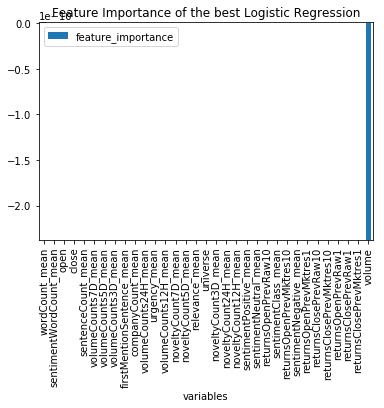

In [22]:
lr_feature_importance.plot.bar(x='variables')
plt.title("Feature Importance of the best Logistic Regression")

In [23]:
print ('The best three features of logistic regression are: {}'.format(lr_feature_importance.variables.values[:3]))

The best three features of logistic regression are: ['wordCount_mean' 'sentimentWordCount_mean' 'open']


In [24]:
lr_feature_importance

,variables,feature_importance
15,wordCount_mean,7.656367e-13
22,sentimentWordCount_mean,3.373194e-13
2,open,8.191438e-14
1,close,8.085569e-14
14,sentenceCount_mean,2.964067e-14
32,volumeCounts7D_mean,1.614974e-14
31,volumeCounts5D_mean,1.134771e-14
30,volumeCounts3D_mean,7.936944e-15
16,firstMentionSentence_mean,5.847310e-15
13,companyCount_mean,5.370107e-15


Seems like Logistic Regression does not give us a really good model to work with even after tunning. Let's try using a different model to see if we could get any thing better. In thid case, I chose to use LightGMB model due to its ability to handle large size dataset and how fast it runs. Light GBM is a gradient boosting framework which uses tree-based learning algorithm. One special thing about this model is its speed in running with large dataset, which makes it a perfect choice for this case, 

In [25]:
#try out lgb
import lightgbm as lgb

params = {'learning_rate': 0.1, 
         'max_depth': 10, 
         'objective': 'binary', 
         'metric': 'auc', 
         'seed': 123}

start_time = time.time()
lgb_model = lgb.train(params, train_set=lgb.Dataset(X_train, label=y_train), 
                     num_boost_round=1000, valid_sets=[lgb.Dataset(X_train, label=y_train), 
                                                      lgb.Dataset(X_test, label=y_test)], 
                     early_stopping_rounds=100)
print ('The training time using LightGBM is: {}'.format(time.time()-start_time))

[1]	valid_0's auc: 0.555536	valid_1's auc: 0.554539
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.556702	valid_1's auc: 0.55589
[3]	valid_0's auc: 0.55784	valid_1's auc: 0.557126
[4]	valid_0's auc: 0.558378	valid_1's auc: 0.557678
[5]	valid_0's auc: 0.558798	valid_1's auc: 0.558115
[6]	valid_0's auc: 0.55909	valid_1's auc: 0.558415
[7]	valid_0's auc: 0.559252	valid_1's auc: 0.558565
[8]	valid_0's auc: 0.559513	valid_1's auc: 0.558831
[9]	valid_0's auc: 0.559726	valid_1's auc: 0.559056
[10]	valid_0's auc: 0.559863	valid_1's auc: 0.559191
[11]	valid_0's auc: 0.560179	valid_1's auc: 0.559465
[12]	valid_0's auc: 0.560299	valid_1's auc: 0.559562
[13]	valid_0's auc: 0.560468	valid_1's auc: 0.559665
[14]	valid_0's auc: 0.560594	valid_1's auc: 0.559782
[15]	valid_0's auc: 0.560737	valid_1's auc: 0.559914
[16]	valid_0's auc: 0.560828	valid_1's auc: 0.559971
[17]	valid_0's auc: 0.56097	valid_1's auc: 0.560125
[18]	valid_0's auc: 0.561159	valid_1's auc: 0.560

[155]	valid_0's auc: 0.569806	valid_1's auc: 0.564516
[156]	valid_0's auc: 0.569829	valid_1's auc: 0.564509
[157]	valid_0's auc: 0.569867	valid_1's auc: 0.564512
[158]	valid_0's auc: 0.569897	valid_1's auc: 0.564511
[159]	valid_0's auc: 0.569922	valid_1's auc: 0.564508
[160]	valid_0's auc: 0.569968	valid_1's auc: 0.564543
[161]	valid_0's auc: 0.570023	valid_1's auc: 0.564559
[162]	valid_0's auc: 0.570071	valid_1's auc: 0.564574
[163]	valid_0's auc: 0.57011	valid_1's auc: 0.564579
[164]	valid_0's auc: 0.57013	valid_1's auc: 0.564578
[165]	valid_0's auc: 0.570168	valid_1's auc: 0.564595
[166]	valid_0's auc: 0.57021	valid_1's auc: 0.564604
[167]	valid_0's auc: 0.570245	valid_1's auc: 0.564603
[168]	valid_0's auc: 0.570292	valid_1's auc: 0.564621
[169]	valid_0's auc: 0.570328	valid_1's auc: 0.564625
[170]	valid_0's auc: 0.570366	valid_1's auc: 0.564632
[171]	valid_0's auc: 0.57039	valid_1's auc: 0.564634
[172]	valid_0's auc: 0.570431	valid_1's auc: 0.564629
[173]	valid_0's auc: 0.570479	va

[308]	valid_0's auc: 0.575318	valid_1's auc: 0.565354
[309]	valid_0's auc: 0.575356	valid_1's auc: 0.565353
[310]	valid_0's auc: 0.575384	valid_1's auc: 0.565352
[311]	valid_0's auc: 0.575418	valid_1's auc: 0.565351
[312]	valid_0's auc: 0.575438	valid_1's auc: 0.565352
[313]	valid_0's auc: 0.575468	valid_1's auc: 0.565338
[314]	valid_0's auc: 0.575479	valid_1's auc: 0.565337
[315]	valid_0's auc: 0.575506	valid_1's auc: 0.565337
[316]	valid_0's auc: 0.575548	valid_1's auc: 0.565342
[317]	valid_0's auc: 0.575578	valid_1's auc: 0.565341
[318]	valid_0's auc: 0.575611	valid_1's auc: 0.565347
[319]	valid_0's auc: 0.575642	valid_1's auc: 0.565353
[320]	valid_0's auc: 0.575681	valid_1's auc: 0.565355
[321]	valid_0's auc: 0.575735	valid_1's auc: 0.565372
[322]	valid_0's auc: 0.575768	valid_1's auc: 0.565371
[323]	valid_0's auc: 0.575793	valid_1's auc: 0.565371
[324]	valid_0's auc: 0.57582	valid_1's auc: 0.565377
[325]	valid_0's auc: 0.575843	valid_1's auc: 0.565375
[326]	valid_0's auc: 0.575871

[461]	valid_0's auc: 0.580154	valid_1's auc: 0.565679
[462]	valid_0's auc: 0.580177	valid_1's auc: 0.565678
[463]	valid_0's auc: 0.580204	valid_1's auc: 0.565683
[464]	valid_0's auc: 0.580218	valid_1's auc: 0.565681
[465]	valid_0's auc: 0.580242	valid_1's auc: 0.565685
[466]	valid_0's auc: 0.580272	valid_1's auc: 0.565685
[467]	valid_0's auc: 0.580293	valid_1's auc: 0.565686
[468]	valid_0's auc: 0.580331	valid_1's auc: 0.565685
[469]	valid_0's auc: 0.580363	valid_1's auc: 0.565679
[470]	valid_0's auc: 0.580395	valid_1's auc: 0.565675
[471]	valid_0's auc: 0.580414	valid_1's auc: 0.565671
[472]	valid_0's auc: 0.58043	valid_1's auc: 0.565674
[473]	valid_0's auc: 0.580451	valid_1's auc: 0.565678
[474]	valid_0's auc: 0.580488	valid_1's auc: 0.565675
[475]	valid_0's auc: 0.580509	valid_1's auc: 0.565667
[476]	valid_0's auc: 0.580548	valid_1's auc: 0.565667
[477]	valid_0's auc: 0.580556	valid_1's auc: 0.56566
[478]	valid_0's auc: 0.580597	valid_1's auc: 0.565667
[479]	valid_0's auc: 0.580617	

[614]	valid_0's auc: 0.584633	valid_1's auc: 0.565851
[615]	valid_0's auc: 0.584667	valid_1's auc: 0.565856
[616]	valid_0's auc: 0.584683	valid_1's auc: 0.56586
[617]	valid_0's auc: 0.584705	valid_1's auc: 0.565859
[618]	valid_0's auc: 0.584725	valid_1's auc: 0.56586
[619]	valid_0's auc: 0.584748	valid_1's auc: 0.565862
[620]	valid_0's auc: 0.584769	valid_1's auc: 0.565864
[621]	valid_0's auc: 0.58479	valid_1's auc: 0.565868
[622]	valid_0's auc: 0.584812	valid_1's auc: 0.565861
[623]	valid_0's auc: 0.584841	valid_1's auc: 0.565861
[624]	valid_0's auc: 0.584871	valid_1's auc: 0.565859
[625]	valid_0's auc: 0.584892	valid_1's auc: 0.565851
[626]	valid_0's auc: 0.584934	valid_1's auc: 0.565844
[627]	valid_0's auc: 0.584977	valid_1's auc: 0.565857
[628]	valid_0's auc: 0.585005	valid_1's auc: 0.565859
[629]	valid_0's auc: 0.585041	valid_1's auc: 0.565852
[630]	valid_0's auc: 0.585058	valid_1's auc: 0.565852
[631]	valid_0's auc: 0.585092	valid_1's auc: 0.56586
[632]	valid_0's auc: 0.585113	va

[767]	valid_0's auc: 0.588929	valid_1's auc: 0.566039
[768]	valid_0's auc: 0.58895	valid_1's auc: 0.566036
[769]	valid_0's auc: 0.588963	valid_1's auc: 0.566028
[770]	valid_0's auc: 0.588981	valid_1's auc: 0.566027
[771]	valid_0's auc: 0.589004	valid_1's auc: 0.56603
[772]	valid_0's auc: 0.589033	valid_1's auc: 0.566027
[773]	valid_0's auc: 0.589069	valid_1's auc: 0.566031
[774]	valid_0's auc: 0.589114	valid_1's auc: 0.56604
[775]	valid_0's auc: 0.58914	valid_1's auc: 0.566045
[776]	valid_0's auc: 0.589178	valid_1's auc: 0.566054
[777]	valid_0's auc: 0.589199	valid_1's auc: 0.566052
[778]	valid_0's auc: 0.589232	valid_1's auc: 0.566064
[779]	valid_0's auc: 0.589243	valid_1's auc: 0.566068
[780]	valid_0's auc: 0.589262	valid_1's auc: 0.566073
[781]	valid_0's auc: 0.589282	valid_1's auc: 0.566077
[782]	valid_0's auc: 0.589326	valid_1's auc: 0.566079
[783]	valid_0's auc: 0.589342	valid_1's auc: 0.566077
[784]	valid_0's auc: 0.589367	valid_1's auc: 0.566072
[785]	valid_0's auc: 0.589374	va

[920]	valid_0's auc: 0.5929	valid_1's auc: 0.566206
[921]	valid_0's auc: 0.592927	valid_1's auc: 0.566204
[922]	valid_0's auc: 0.592959	valid_1's auc: 0.566205
[923]	valid_0's auc: 0.592989	valid_1's auc: 0.566204
[924]	valid_0's auc: 0.593026	valid_1's auc: 0.566214
[925]	valid_0's auc: 0.593057	valid_1's auc: 0.566216
[926]	valid_0's auc: 0.593083	valid_1's auc: 0.56622
[927]	valid_0's auc: 0.593115	valid_1's auc: 0.56623
[928]	valid_0's auc: 0.59313	valid_1's auc: 0.566224
[929]	valid_0's auc: 0.593158	valid_1's auc: 0.566215
[930]	valid_0's auc: 0.593191	valid_1's auc: 0.566208
[931]	valid_0's auc: 0.593211	valid_1's auc: 0.566206
[932]	valid_0's auc: 0.593229	valid_1's auc: 0.566208
[933]	valid_0's auc: 0.593258	valid_1's auc: 0.56621
[934]	valid_0's auc: 0.593283	valid_1's auc: 0.566209
[935]	valid_0's auc: 0.593291	valid_1's auc: 0.566205
[936]	valid_0's auc: 0.593318	valid_1's auc: 0.566204
[937]	valid_0's auc: 0.593337	valid_1's auc: 0.566208
[938]	valid_0's auc: 0.593369	vali

In [26]:
lgb_feature_importance = pd.DataFrame({'variables': X_train.columns.tolist(),
                                       'feature_importance': lgb_model.feature_importance()})
lgb_feature_importance = lgb_feature_importance.sort_values('feature_importance', ascending=False)

Text(0.5,1,'Feature Importance of the LightGBM')

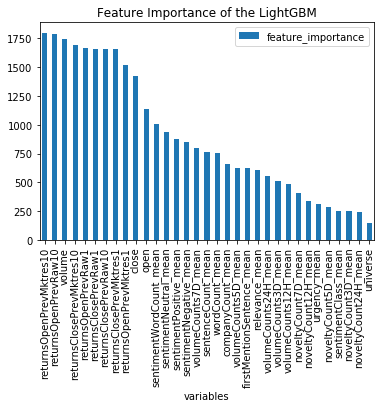

In [27]:
lgb_feature_importance.plot.bar(x='variables')
plt.title("Feature Importance of the LightGBM")

In [28]:
print ('The best three features of LightGBM are: {}'.format(lgb_feature_importance.variables.values[:3]))

The best three features of LightGBM are: ['returnsOpenPrevMktres10' 'returnsOpenPrevRaw10' 'volume']


In [29]:
lgb_feature_importance

,variables,feature_importance
10,returnsOpenPrevMktres10,1800
8,returnsOpenPrevRaw10,1785
0,volume,1742
9,returnsClosePrevMktres10,1690
4,returnsOpenPrevRaw1,1666
3,returnsClosePrevRaw1,1662
7,returnsClosePrevRaw10,1659
5,returnsClosePrevMktres1,1657
6,returnsOpenPrevMktres1,1520
1,close,1425


In comparison between the two models, it shoes that the LightGBM is a better model which give s a better accuracry score and efficiency. It would be ideal if we can further tune this model to find a better accuracy before making any prediction. 

## LIGHTGBM TUNING 

To further optimize the accuracy of the LightGBM model, we can vary the following features:
+ use large max_bin
+ use small learning_rate in addition to increasing the num_boost_round
+ use large num_leaves
+ use bigger training dataset (not applicable in our case)
+ try using 'dart' method 
+ or try using categorical features directly

In this case, using large max_bin can signifcantly slow down our working process due to the amount of data points that were given in this project while using a large num_leaves may cause over-fitting. The last option, which is to use categorical features directly are not really appropriate in this scenario since the data-preprocessing already eliminated the categories due to its irrelevance to the ability to predict the market returns. Thus, we can either combine using small learning_rate with increasing the num_boost_round or use 'dart' method to help us improve the accuracy of the LightGBM model. 

In [ ]:
#Try smaller learning_rate and increasing the num_boost_round
params_trial1 = {'learning_rate': 0.01, 
                 'max_depth': 10, 
                 'objective': 'binary', 
                 'metric': 'auc', 
                 'seed': 123}

start_time = time.time()
lgb_model_trial1 = lgb.train(params_trial1, train_set=lgb.Dataset(X_train, label=y_train), 
                             num_boost_round=2000, valid_sets=[lgb.Dataset(X_train, label=y_train),
                                                               lgb.Dataset(X_test, label=y_test)], 
                             early_stopping_rounds=100)
print ('The training time using LightGBM with smaller learning_rate and highern number of boosting rounds is: {}'.format(time.time()-start_time))

In [ ]:
#Try using 'dart' method
params_trial2 = {'learning_rate': 0.1, 
                 'max_depth': 10, 
                 'objective': 'binary', 
                 'metric': 'auc', 
                 'seed': 123, 
                 'boosting_type': 'dart'}

start_time = time.time()
lgb_model_trial2 = lgb.train(params_trial2, train_set=lgb.Dataset(X_train, label=y_train), 
                             num_boost_round=1000, valid_sets=[lgb.Dataset(X_train, label=y_train),
                                                               lgb.Dataset(X_test, label=y_test)], 
                             early_stopping_rounds=100)
print ('The training time using LightGBM with dart as a boosting type is: {}'.format(time.time()-start_time))